# Level 2: Internal Mechanics

In this notebook, we open the "black box". We will visualize the learned weights (kernels) and the resulting feature maps to understand how the CNN processes images.

In [7]:
from tinygrad import Tensor, nn, TinyJit
from tinygrad.nn.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [8]:
# 1. Load Model & Data
# We redefine the model here to be self-contained.

X_train, Y_train, _, _ = mnist()

class Model:
    def __init__(self):
        self.l1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.l2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.l3 = nn.Linear(64 * 7 * 7, 10)

    def __call__(self, x):
        x = self.l1(x).relu().max_pool2d(2)
        x = self.l2(x).relu().max_pool2d(2)
        x = x.flatten(1)
        return self.l3(x)

model = Model()

# Quick training to develop patterns
print("Training briefly to generate non-random patterns...")
opt = nn.optim.Adam(nn.state.get_parameters(model))
batch_size = 128
steps = 256

@TinyJit
def train_step(X: Tensor, Y: Tensor) -> Tensor:
    Tensor.training = True
    opt.zero_grad()
    out = model(X)  # Forward pass: get predictions
    loss = out.sparse_categorical_crossentropy(Y)  # Compare predictions to ground truth
    loss.backward()
    opt.step()
    return loss

for i in range(steps):
    # Sample random batch
    samples = Tensor.randint(batch_size, high=X_train.shape[0])
    X, Y = X_train[samples], Y_train[samples]
    loss = train_step(X, Y)

print("Done.")

Training briefly to generate non-random patterns...
Done.


Layer 1 Weights Shape: (32, 1, 3, 3) (Out, In, H, W)


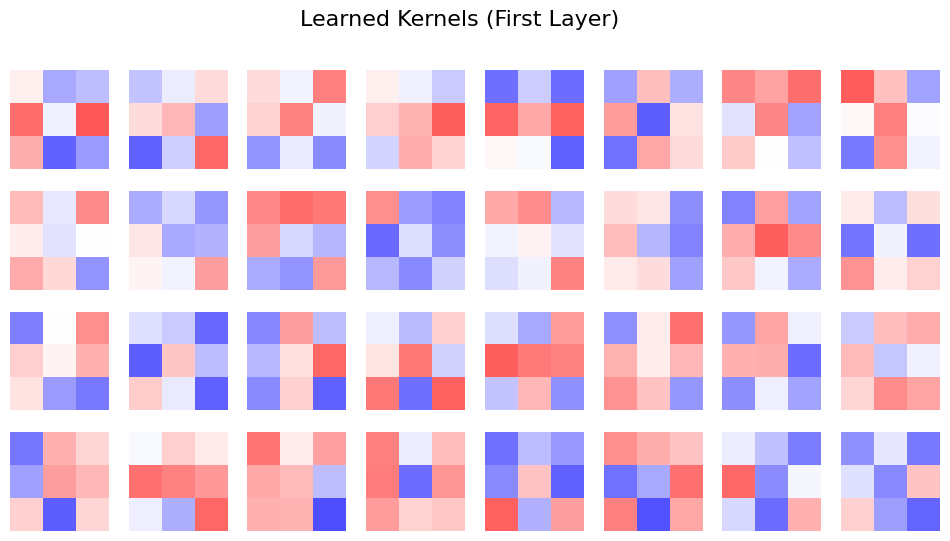

In [9]:
# 2. Kernel Visualization
# Access the weights of the first layer
weights = model.l1.weight.numpy()
print(f"Layer 1 Weights Shape: {weights.shape} (Out, In, H, W)")

# Plot the 32 filters (3x3 each)
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
fig.suptitle("Learned Kernels (First Layer)", fontsize=16)

for i, ax in enumerate(axes.flatten()):
    if i < 32:
        # Get the i-th filter, 0-th channel
        w = weights[i, 0]
        # Use bwr colormap: Blue (negative), White (zero), Red (positive)
        im = ax.imshow(w, cmap='bwr', vmin=-0.5, vmax=0.5)
        ax.axis('off')
plt.show()

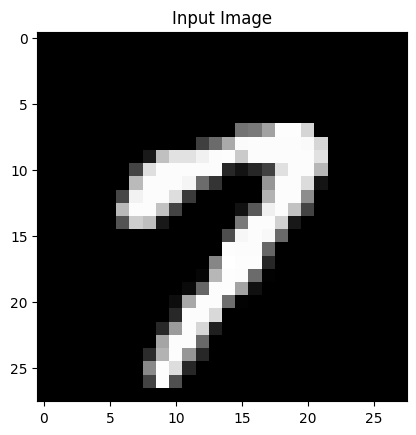

Feature Maps Shape: (1, 32, 28, 28)


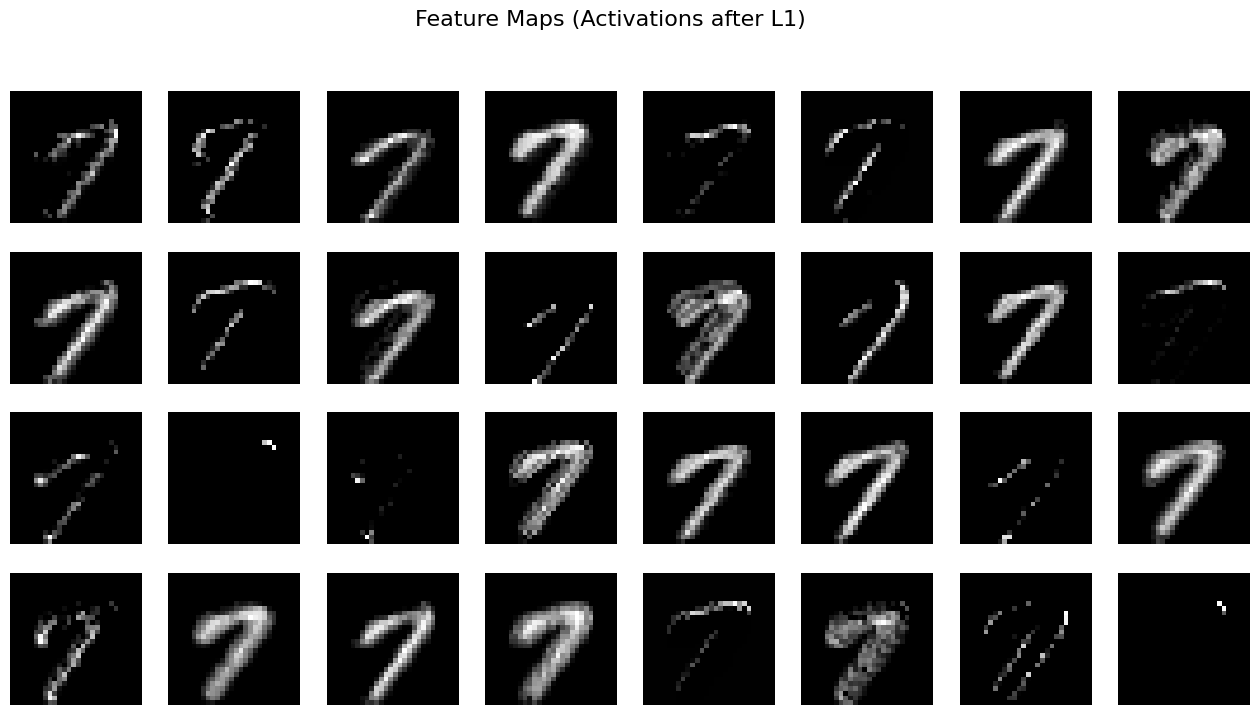

In [10]:
# 3. Feature Map Visualization
# What does the network "see" after the first layer?

# Pick a random image (e.g. a 7)
img_idx = int(np.where(Y_train.numpy() == 7)[0][0])
input_img = X_train[img_idx].reshape(1, 1, 28, 28)

plt.imshow(input_img.numpy().reshape(28, 28), cmap='gray')
plt.title("Input Image")
plt.show()

# Pass through L1 + ReLU
# Note: We call .realize() to ensure computation happens if lazy
feature_maps = model.l1(input_img).relu().numpy()

print(f"Feature Maps Shape: {feature_maps.shape}")

fig, axes = plt.subplots(4, 8, figsize=(16, 8))
fig.suptitle("Feature Maps (Activations after L1)", fontsize=16)

for i, ax in enumerate(axes.flatten()):
    if i < 32:
        fm = feature_maps[0, i]
        ax.imshow(fm, cmap='gray')
        ax.axis('off')
plt.show()